# TODO: Explore data, preprocess data, tune hyperparameters, repeat...

There's a weird like x^3 curve in our residuals so we gotta do more data exploration :(
<br>To keep our repository cleaner, I moved some stuff to a processing file so this model will be explicity for modeling

### Prepping Data

In [17]:
import sys
sys.dont_write_bytecode = True

# uncomment load_ext line when you initially use the file, after you can comment to get rid of the warning that'll show up
# %load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from data_processing import prepData, transformData
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold, cross_val_score # for training a model
from sklearn.metrics import mean_squared_error, r2_score # for finding r2 and MSE
from mlxtend.evaluate import bias_variance_decomp

cv = KFold(n_splits=5, shuffle=True, random_state=1) # for cross validation

path = '../data/bike.csv'
df = pd.read_csv(path, encoding_errors='ignore', parse_dates=['Date'], dayfirst=True)
pd.set_option('display.max_columns', None) # lets you scroll if your monitor isn't wide enough

df = prepData(df)
display(df)

,Rented Bike Count,Temperature(C),Humidity(%),Wind Speed(m/s),Solar Radiation(MJ/m2),Rainfall(mm),Snowfall(mm),Spring,Summer,Autumn,Winter,Weekend,Summer*Temp
Date,,,,,,,,,,,,,
2017-12-01,9539,-2.454167,45.875000,1.537500,1.16,0.0,0.0,0,0,0,1,0,-0.0
2017-12-02,8523,1.325000,61.958333,1.712500,1.12,0.0,0.0,0,0,0,1,1,0.0
2017-12-03,7222,4.875000,81.541667,1.612500,0.69,4.0,0.0,0,0,0,1,1,0.0
2017-12-04,8729,-0.304167,52.500000,3.450000,1.17,0.1,0.0,0,0,0,1,0,-0.0
2017-12-05,8307,-4.458333,36.416667,1.108333,0.64,0.0,0.0,0,0,0,1,0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,17162,6.320833,70.500000,1.029167,1.74,0.0,29.0,0,0,1,0,0,0.0
2018-11-27,16282,7.066667,68.000000,1.350000,0.87,0.0,0.0,0,0,1,0,0,0.0
2018-11-28,16524,5.304167,25.791667,1.695833,1.86,0.0,0.0,0,0,1,0,0,0.0


In [18]:
y = df['Rented Bike Count'].to_numpy() # target value
X = df.drop('Rented Bike Count', axis=1) # taking out the target value

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

X_train, X_test, y_train, y_test = transformData(X_train, X_test, y_train, y_test)

## Things to look for going into testing models
From the slides, there's a few models we can knock off our list
- We're targeting a numerical value so that means we'll need a regression model (minimizing mse and rmse, maximizing r2)
- We'll need for it to handle multicollinearity because weather effects are usually correlated with each other
- We've scaled down rainfall and snowfall but we still have outliers so it should handle those well

I looked up a good chunk of the regression models on sklearn and imported them

In [5]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.linear_model import ARDRegression, ElasticNet, ElasticNetCV, HuberRegressor, Lars, LarsCV, Lasso, LassoCV, LassoLarsCV, LassoLarsIC, LinearRegression
from sklearn.linear_model import QuantileRegressor, RANSACRegressor, Ridge, RidgeCV, SGDRegressor, BayesianRidge
from sklearn.linear_model import TheilSenRegressor, TweedieRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor,  HistGradientBoostingRegressor, RandomForestRegressor

# Model Testing
I've separated the model testing into 2 parts
- Part 1: Testing default values for almost every regression model on sklearn
- Part 2: From the best performing models in part 1, try out some hyperparameter combinations
## Part 1

In [19]:
all_model = { # random_state=1 for reproductability
    'DecisionTree' : DecisionTreeRegressor(random_state=1),
    'ExtraTree' : ExtraTreeRegressor(random_state=1),
    'KNeighbors' : KNeighborsRegressor(),
    'KernelRidge' : KernelRidge(),
    'LinearSVR' : LinearSVR(random_state=1),
    'SVR' : SVR(),
    'NuSVR' : NuSVR(),
    'ARDRegression' : ARDRegression(),
    'ElasticNet' : ElasticNet(random_state=1),
    'ElasticNetCV' : ElasticNetCV(random_state=1),
    'HuberRegressor' : HuberRegressor(),
    'Lars' : Lars(random_state=1),
    'LarsCV' : LarsCV(),
    'Lasso' : Lasso(random_state=1),
    'LassoCV' : LassoCV(random_state=1),
    'LassoLarsCV' : LassoLarsCV(),
    'LassoLarsIC' : LassoLarsIC(),
    'LinearRegression' : LinearRegression(),
    'QuantileRegressor' : QuantileRegressor(),
    'RANSACRegressor' : RANSACRegressor(random_state=1),
    'Ridge' : Ridge(random_state=1),
    'RidgeCV' : RidgeCV(),
    'SGDRegressor' : SGDRegressor(random_state=1),
    'BayesianRidge' : BayesianRidge(),
    'TheilSenRegressor' : TheilSenRegressor(random_state=1),
    'TweedieRegressor' : TweedieRegressor(),
    'ExtraTreesRegressor' : ExtraTreesRegressor(random_state=1),
    'GradientBoostingRegressor' : GradientBoostingRegressor(random_state=1),
    'HistGradientBoostingRegressor' : HistGradientBoostingRegressor(random_state=1),
    'RandomForestRegressor' : RandomForestRegressor(random_state=1),
    'XGBRegressor' : XGBRegressor()
    }

screening = [] # our output

for name, model in all_model.items():
    print(name) # for debugging

    reg = model.fit(X_train, y_train)

    train_pred = reg.predict(X_train)
    test_pred = reg.predict(X_test)
    
    cv_r2_score = round(np.mean(cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2')), 2)
    r2_train = round(r2_score(y_train, train_pred), 2)
    r2_test = round(r2_score(y_test, test_pred), 2)
    mse_train = round(mean_squared_error(y_train, train_pred), 2)
    mse_test = round(mean_squared_error(y_test, test_pred), 2)
    rmse = np.sqrt(mse_test)
    screening.append([name, r2_test, r2_train, mse_test, mse_train, rmse, cv_r2_score])

# converting output to a dataframe and adding column names
screening_df = pd.DataFrame(screening, columns=('model', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'rmse', 'cv_r2_score'))

# makes it easier to find overfitting, should be positive
screening_df['r2_diff'] = screening_df['r2_test'] - screening_df['r2_train']

# makes it easier to find overfitting, should be negative
screening_df['mse_diff'] = screening_df['mse_test'] - screening_df['mse_train']

clear_output(True) # clean up output
display(screening_df.sort_values(['r2_test', 'r2_diff'], ascending=False))

,model,r2_test,r2_train,mse_test,mse_train,rmse,cv_r2_score,r2_diff,mse_diff
28,HistGradientBoostingRegressor,0.91,0.98,8.474796e+06,1.902001e+06,2911.150235,0.90,-0.07,6.572794e+06
27,GradientBoostingRegressor,0.91,0.99,8.720632e+06,1.381633e+06,2953.071579,0.91,-0.08,7.338998e+06
26,ExtraTreesRegressor,0.91,1.00,8.744987e+06,0.000000e+00,2957.192402,0.92,-0.09,8.744987e+06
29,RandomForestRegressor,0.88,0.99,1.124534e+07,1.279840e+06,3353.406484,0.90,-0.11,9.965495e+06
30,XGBRegressor,0.88,1.00,1.153396e+07,7.998000e+01,3396.169165,0.87,-0.12,1.153389e+07
22,SGDRegressor,0.87,0.88,1.292549e+07,1.168650e+07,3595.203435,0.87,-0.01,1.238986e+06
3,KernelRidge,0.87,0.89,1.277465e+07,1.143433e+07,3574.164565,0.87,-0.02,1.340324e+06
20,Ridge,0.87,0.89,1.277293e+07,1.132789e+07,3573.923210,0.87,-0.02,1.445034e+06
7,ARDRegression,0.86,0.90,1.324375e+07,9.514081e+06,3639.196424,0.89,-0.04,3.729669e+06
10,HuberRegressor,0.86,0.90,1.297719e+07,9.776500e+06,3602.386559,0.89,-0.04,3.200689e+06


In [20]:
# finding models that have similar r2 for train and test and have good values
display(screening_df.loc[(screening_df['r2_diff']>=-0.15) & (screening_df['r2_test']>=0.70)].sort_values(['r2_diff', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,rmse,cv_r2_score,r2_diff,mse_diff
8,ElasticNet,0.77,0.76,22130364.52,24141674.84,4704.292138,0.75,0.01,-2011310.32
22,SGDRegressor,0.87,0.88,12925487.74,11686502.02,3595.203435,0.87,-0.01,1238985.72
20,Ridge,0.87,0.89,12772927.11,11327892.72,3573.923210,0.87,-0.02,1445034.39
3,KernelRidge,0.87,0.89,12774652.34,11434328.40,3574.164565,0.87,-0.02,1340323.94
10,HuberRegressor,0.86,0.90,12977188.92,9776499.82,3602.386559,0.89,-0.04,3200689.10
21,RidgeCV,0.86,0.90,12991644.22,9544345.42,3604.392351,0.89,-0.04,3447298.80
14,LassoCV,0.86,0.90,13060694.90,9519869.63,3613.958342,0.89,-0.04,3540825.27
23,BayesianRidge,0.86,0.90,13091604.60,9512488.43,3618.232248,0.89,-0.04,3579116.17
7,ARDRegression,0.86,0.90,13243750.61,9514081.36,3639.196424,0.89,-0.04,3729669.25
13,Lasso,0.86,0.90,13284371.69,9487996.87,3644.773201,0.89,-0.04,3796374.82


In [ ]:
display(screening_df.iloc[[8, 10, 26]])

,model,r2_test,r2_train,mse_test,mse_train,rmse,cv_r2_score,r2_diff,mse_diff
8,ElasticNet,0.73,0.72,26151334.28,27579974.00,5113.837530,0.71,0.01,-1428639.72
10,HuberRegressor,0.85,0.88,14024633.96,11952455.81,3744.947791,0.86,-0.03,2072178.15
26,ExtraTreesRegressor,0.89,1.00,10705527.28,0.00,3271.930207,0.90,-0.11,10705527.28


# Models we'll be working with
Throughout all data manipulation, Huber consistently does ok so it's gotta be fate or something
- HuberRegressor (L2, regularizer that's good w outliers, reduces overfitting) i'll stop saying punishes from now on to not bother you kenzy
- ElasticNet (need an "initial model" for the slides)
- ExtraTreesRegressor (To say that we at least tried a tree-based model)

## Part 2: Tuning hyperparameters
- n_jobs=* declares how many processors your computer will use; -1 uses all. Change at your own risk
<p>If a hyperparameter isn't listed for a model then it doesn't have a significant effect on its performance (based off my testing (byron))

In [28]:
param_dict = {
    'HuberRegressor' : {
        'epsilon' : [1.0, 1.35, 2.0, 5.0],
        'alpha': [1e-5, 1e-3, 0.1, 1],
        'max_iter': [100, 250, 500, 1000]},
    'ElasticNet' : {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        'l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]},
    'ExtraTreesRegressor' : {
        'max_depth' : [6, 15, 30],
        'min_samples_split' : [2, 9, 12, 50, 100],
        'min_samples_leaf' : [1, 10, 13, 50, 100],
        'n_estimators': [5, 50, 100, 500]},
    'Ridge' : {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    'SGDRegressor' : {
        'alpha': [0.0001, 0.001, 0.01],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'l1_ratio': [0.15, 0.5, 0.9],  # only used if penalty='elasticnet'
        'max_iter': [1000, 2000],
        'learning_rate': ['optimal', 'invscaling', 'adaptive'],
        'eta0': [0.01, 0.1, 1]
    }
}

model_dict = {
    'HuberRegressor' : HuberRegressor(),
    'ElasticNet' : ElasticNet(random_state=1),
    'ExtraTreesRegressor' : ExtraTreesRegressor(random_state=1, n_jobs=-1),
    'Ridge' : Ridge(random_state=1),
    'SGDRegressor' : SGDRegressor(random_state=1)
}

### Bayesian Optimization

In [9]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
import copy
from sklearn.exceptions import ConvergenceWarning

# common warning because bayesian search tries not to redo configurations when picking random ones
warnings.filterwarnings("ignore", message="The objective has been evaluated at point")

# bayes might try low # of iterations, better to ignore this warning than see it 10 billion times
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# only run the specified models and pick the top n by their r2 
def baye_searcher(models_to_run, top_n=10):
    summary = [] # our output

    for name, model in model_dict.items(): # iterate through all available models
        if name not in models_to_run:  # only uses the selected models
            continue

        start_time = time.time() # for tracking time
        print(f"Now working on {name}")

        # BayesSearch uses search spaces instead of param grids so we have to convert
        search_space = copy.deepcopy(param_dict[name])
        for param, values, in search_space.items():
            if isinstance(values[0], str):
                search_space[param] = tuple(values)
            if isinstance(values[0], bool):
                search_space[param] = Categorical(categories=(False, True))
            if isinstance(values[0], int):
                search_space[param] = Integer(min(values), max(values))
            if isinstance(values[0], float):
                search_space[param] = Real(min(values), max(values))

        # finds the best model configuration to maximize R2
        iterations = 20 # defaults to 20 iterations unless we specify we want more
        if top_n > iterations: iterations = top_n
        b_search = BayesSearchCV(estimator=model, search_spaces=search_space, cv=cv, random_state=1, scoring='r2', return_train_score=True, n_jobs=-1, n_iter=iterations, n_points=4)
        b_search.fit(X_train, y_train)

        # upload all configuration scores into dataframe and grab only the top n performing that have the least overfitting
        results = pd.DataFrame(b_search.cv_results_)
        results['r2_diff'] = results['mean_test_score'] - results['mean_train_score']
        results = results.sort_values('r2_diff', ascending=False).head(top_n)

        for i, row in results.iterrows(): # iterate through top n configurations
            params = row['params']
            best_model = model.set_params(**params)  # refit model to the current parameters
            try:
                best_model.fit(X_train, y_train)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            # these are here so we can dynamically add as many columns as there are params and values
            param_keys = list(params.keys())
            param_values = list(params.values())

            train_pred = best_model.predict(X_train)
            test_pred = best_model.predict(X_test)
            
            # gathering metrics
            r2_train = round(r2_score(y_train, train_pred), 3)
            r2_test = round(r2_score(y_test, test_pred), 3)
            mse_train = round(mean_squared_error(y_train, train_pred), 3)
            mse_test = round(mean_squared_error(y_test, test_pred), 3)
            rmse = np.sqrt(mse_test)
            try:
                loss, bias, var = bias_variance_decomp(
                    best_model, X_train, y_train, X_test, y_test, loss='mse', random_seed=1)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            summary.append([name, param_keys, param_values, r2_test, r2_train, mse_test, mse_train, loss, bias, var, rmse])
        end_time = time.time()
        print(f"{name} took {end_time - start_time:.2f} seconds")

    # converting output to a dataframe and adding column names
    summary_df = pd.DataFrame(summary, columns=('model', 'param_names', 'param_values', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'loss', 'bias', 'vari', 'rmse'))

    # makes it easier to find overfitting, should be positive
    summary_df['r2_diff'] = summary_df['r2_test'] - summary_df['r2_train']

    # makes it easier to find overfitting, should be negative
    summary_df['mse_diff'] = summary_df['mse_test'] - summary_df['mse_train']

    # find the max number of parameters for all the models
    max_params = max(summary_df['param_names'].apply(len))

    # dynamically adding as many columns as there are params and values; also padding with placeholders in case different models dont have the same number
    summary_df['param_names'] = summary_df['param_names'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))
    summary_df['param_values'] = summary_df['param_values'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))

    # insert param names and values
    for i in range(max_params):
        summary_df[f'param{i+1}'] = summary_df['param_names'].apply(lambda x: x[i])
        summary_df[f'val{i+1}'] = summary_df['param_values'].apply(lambda x: x[i])

    # Drop original columns
    summary_df = summary_df.drop(columns=['param_names', 'param_values'])

    return summary_df

Bayesian Search is a fast way to find good parameters
<br>This is useful for determining which parameters dont affect our accuracy

### Grid Search
More time consuming because it tries every configuration in our param dictionary and finds the best one

In [10]:
from sklearn.model_selection import GridSearchCV

# only run the specified models and pick the top n by their r2 
def grid_searcher(models_to_run, top_n=10):
    summary = [] # our output

    for name, model in model_dict.items(): # iterate through all available models
        if name not in models_to_run:  # only uses the selected models
            continue

        start_time = time.time() # for tracking time
        print(f"Now working on {name}")
        # finds the best model configuration to maximize R2
        grid_search = GridSearchCV(estimator=model, param_grid=param_dict[name], scoring='r2', cv=cv, n_jobs=-1, return_train_score=True)
        grid_search.fit(X_train, y_train)

        # upload all configuration scores into dataframe and grab only the top n performing that have the least overfitting
        results = pd.DataFrame(grid_search.cv_results_)
        results['r2_diff'] = results['mean_test_score'] - results['mean_train_score']
        if top_n > len(results): top_n = len(results)
        results = results.sort_values('r2_diff', ascending=False).head(top_n)

        for i, row in results.iterrows(): # iterate through top n configurations
            params = row['params']
            best_model = model.set_params(**params)  # refit model to the current parameters
            try:
                best_model.fit(X_train, y_train)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            # these are here so we can dynamically add as many columns as there are params and values
            param_keys = list(params.keys())
            param_values = list(params.values())
        
            train_pred = best_model.predict(X_train)
            test_pred = best_model.predict(X_test)

            # gathering metrics
            r2_train = round(r2_score(y_train, train_pred), 3)
            r2_test = round(r2_score(y_test, test_pred), 3)
            mse_train = round(mean_squared_error(y_train, train_pred), 3)
            mse_test = round(mean_squared_error(y_test, test_pred), 3)
            rmse = np.sqrt(mse_test)
            try:
                loss, bias, var = bias_variance_decomp(
                    best_model, X_train, y_train, X_test, y_test, loss='mse', random_seed=1)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            summary.append([name, param_keys, param_values, r2_test, r2_train, mse_test, mse_train, loss, bias, var, rmse])
        end_time = time.time()
        print(f"{name} took {end_time - start_time:.2f} seconds")

    # adding column names
    summary_df = pd.DataFrame(summary, columns=('model', 'param_names', 'param_values', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'loss', 'bias', 'vari', 'rmse'))

    # makes it easier to find overfitting, should be positive
    summary_df['r2_diff'] = summary_df['r2_test'] - summary_df['r2_train']

    # makes it easier to find overfitting, should be negative
    summary_df['mse_diff'] = summary_df['mse_test'] - summary_df['mse_train']

    # find the max number of parameters for all the models
    max_params = max(summary_df['param_names'].apply(len))

    # dynamically adding as many columns as there are params and values; also padding with placeholders in case different models dont have the same number
    summary_df['param_names'] = summary_df['param_names'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))
    summary_df['param_values'] = summary_df['param_values'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))

    # insert param names and values
    for i in range(max_params):
        summary_df[f'param{i+1}'] = summary_df['param_names'].apply(lambda x: x[i])
        summary_df[f'val{i+1}'] = summary_df['param_values'].apply(lambda x: x[i])

    # Drop original columns
    summary_df = summary_df.drop(columns=['param_names', 'param_values'])

    return summary_df

I put it in a separate function because it takes forever and I (byron) don't want to leave my pc on for hours waiting
<br>This way we can do a few models at a time and keep the output
<p>Out of the 3 tuning methods, I only implemented Bayesian and Grid Searching
<br>Bayesian is a more generalized method that sometimes finds the exact parameter values that work best
<br>Grid on the other hand, only uses the parameter values we give it. That makes it better for fine tuning

In [23]:
tune_params = ['Ridge']
tune = baye_searcher(tune_params, 50)

Now working on Ridge
Ridge took 30.22 seconds


In [24]:
tune0_params = ['Ridge']
tune0 = grid_searcher(tune0_params, 50)

Now working on Ridge
Ridge took 0.95 seconds


In [27]:
tune0_results = pd.concat([tune0, tune], axis=0)
display(tune0_results.loc[(tune0_results['r2_diff']>=-0.005) & (tune0_results['r2_test']>=0.8)].sort_values(['r2_test', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,loss,bias,vari,rmse,r2_diff,mse_diff,param1,val1
4,Ridge,0.844,0.837,1.500584e+07,1.618431e+07,1.573476e+07,1.507078e+07,663982.768835,3873.737477,0.007,-1178471.913,alpha,10.000000
42,Ridge,0.841,0.833,1.527999e+07,1.665067e+07,1.596756e+07,1.533950e+07,628060.049157,3908.963022,0.008,-1370676.128,alpha,13.450037
41,Ridge,0.831,0.819,1.625711e+07,1.802039e+07,1.683212e+07,1.632021e+07,511911.824943,4032.010769,0.012,-1763278.645,alpha,29.412277
40,Ridge,0.810,0.797,1.822794e+07,2.022493e+07,1.874930e+07,1.832907e+07,420227.494712,4269.418913,0.013,-1996992.490,alpha,61.652670


In [18]:
tune1_params = ['HuberRegressor']
tune1 = baye_searcher(tune1_params, 50)

Now working on HuberRegressor
HuberRegressor took 112.74 seconds


In [19]:
tune12_params = ['HuberRegressor']
tune12 = grid_searcher(tune12_params, 50)

Now working on HuberRegressor
HuberRegressor took 115.08 seconds


In [22]:
tune1_results = pd.concat([tune1, tune12], axis=0)
display(tune1_results.loc[(tune1_results['r2_diff']>=0) & (tune1_results['r2_test']>=0.8)].sort_values(['r2_test', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,loss,bias,vari,rmse,r2_diff,mse_diff,param1,val1,param2,val2,param3,val3
48,HuberRegressor,0.832,0.825,1.616084e+07,1.741771e+07,1.759339e+07,1.619527e+07,1.398118e+06,4020.054249,0.007,-1256873.959,alpha,0.001000,epsilon,1.350000,max_iter,100
49,HuberRegressor,0.832,0.825,1.616084e+07,1.741771e+07,1.759339e+07,1.619527e+07,1.398118e+06,4020.054249,0.007,-1256873.959,alpha,0.001000,epsilon,1.350000,max_iter,1000
24,HuberRegressor,0.831,0.823,1.624736e+07,1.764513e+07,1.771378e+07,1.623440e+07,1.479384e+06,4030.801902,0.008,-1397768.109,alpha,0.001427,epsilon,1.228780,max_iter,917
28,HuberRegressor,0.830,0.822,1.629615e+07,1.769238e+07,1.806185e+07,1.628043e+07,1.781419e+06,4036.849096,0.008,-1396226.748,alpha,0.000683,epsilon,1.190944,max_iter,723
39,HuberRegressor,0.830,0.821,1.632152e+07,1.776043e+07,1.857181e+07,1.636166e+07,2.210153e+06,4039.989877,0.009,-1438908.120,alpha,0.000022,epsilon,1.152983,max_iter,266
48,HuberRegressor,0.830,0.827,1.632635e+07,1.723959e+07,1.767546e+07,1.635529e+07,1.320169e+06,4040.587539,0.003,-913246.340,alpha,0.000382,epsilon,1.522966,max_iter,1000
29,HuberRegressor,0.830,0.821,1.633191e+07,1.783855e+07,1.856143e+07,1.636714e+07,2.194287e+06,4041.275676,0.009,-1506645.130,alpha,0.000231,epsilon,1.117728,max_iter,593
22,HuberRegressor,0.829,0.825,1.641217e+07,1.735425e+07,1.718340e+07,1.640352e+07,7.798748e+05,4051.194173,0.004,-942073.853,alpha,0.001955,epsilon,5.000000,max_iter,1000
21,HuberRegressor,0.829,0.824,1.641698e+07,1.752042e+07,1.711227e+07,1.640104e+07,7.112218e+05,4051.787756,0.005,-1103432.334,alpha,0.002859,epsilon,4.778649,max_iter,227
36,HuberRegressor,0.829,0.827,1.642384e+07,1.720109e+07,1.756506e+07,1.644053e+07,1.124531e+06,4052.634219,0.002,-777246.754,alpha,0.000538,epsilon,1.739705,max_iter,181


In [26]:
tune2_params = ['ElasticNet']
tune2 = baye_searcher(tune2_params, 50)

Now working on ElasticNet
ElasticNet took 33.99 seconds


In [27]:
tune22_params = ['ElasticNet']
tune22 = grid_searcher(tune22_params, 50)

Now working on ElasticNet
ElasticNet took 19.11 seconds


In [29]:
tune2_results = pd.concat([tune2, tune22], axis=0)
display(tune2_results.loc[(tune2_results['r2_diff']>=0) & (tune2_results['r2_test']>=0.8)].sort_values(['r2_test', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,loss,bias,vari,rmse,r2_diff,mse_diff,param1,val1,param2,val2
16,ElasticNet,0.829,0.824,1.640897e+07,1.749374e+07,1.711291e+07,1.639880e+07,714104.197673,4050.798352,0.005,-1084773.821,alpha,0.623051,l1_ratio,0.926342
15,ElasticNet,0.829,0.824,1.642121e+07,1.753818e+07,1.710868e+07,1.640985e+07,698827.397729,4052.309098,0.005,-1116967.910,alpha,0.100000,l1_ratio,0.500000
17,ElasticNet,0.829,0.826,1.643395e+07,1.727422e+07,1.725625e+07,1.643633e+07,819917.377842,4053.880328,0.003,-840273.717,alpha,9.174733,l1_ratio,0.997639
16,ElasticNet,0.829,0.826,1.644849e+07,1.727751e+07,1.726176e+07,1.644267e+07,819092.631927,4055.673735,0.003,-829025.151,alpha,0.100000,l1_ratio,0.750000
14,ElasticNet,0.827,0.821,1.655815e+07,1.783624e+07,1.716782e+07,1.654819e+07,619626.931478,4069.171252,0.006,-1278084.249,alpha,0.100000,l1_ratio,0.250000
17,ElasticNet,0.827,0.827,1.665059e+07,1.716238e+07,1.758907e+07,1.665931e+07,929752.330396,4080.512971,0.000,-511794.473,alpha,0.100000,l1_ratio,0.900000
18,ElasticNet,0.827,0.827,1.665108e+07,1.716219e+07,1.758997e+07,1.665996e+07,930010.915381,4080.573349,0.000,-511114.249,alpha,0.010000,l1_ratio,0.000000
13,ElasticNet,0.826,0.819,1.667969e+07,1.802451e+07,1.725597e+07,1.667203e+07,583934.661005,4084.077528,0.007,-1344824.427,alpha,0.100000,l1_ratio,0.100000
12,ElasticNet,0.825,0.817,1.677133e+07,1.815262e+07,1.732931e+07,1.676561e+07,563700.950556,4095.281038,0.008,-1381295.925,alpha,0.100000,l1_ratio,0.000000
11,ElasticNet,0.825,0.817,1.677153e+07,1.815680e+07,1.732958e+07,1.676663e+07,562942.122456,4095.305939,0.008,-1385267.169,alpha,1.000000,l1_ratio,0.900000


In [30]:
tune3_params = ['ExtraTreesRegressor']
tune3 = baye_searcher(tune3_params, 50)

Now working on ExtraTreesRegressor
ExtraTreesRegressor took 2675.88 seconds


In [31]:
tune32_params = ['ExtraTreesRegressor']
tune32 = grid_searcher(tune32_params, 50)

Now working on ExtraTreesRegressor
ExtraTreesRegressor took 1786.36 seconds


In [33]:
tune3_results = pd.concat([tune3, tune32], axis=0)
display(tune3_results.loc[(tune3_results['r2_diff']>=-0.01) & (tune3_results['r2_test']>=0.8)].sort_values(['r2_test', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,loss,bias,vari,rmse,r2_diff,mse_diff,param1,val1,param2,val2,param3,val3,param4,val4


In [29]:
tune11_params = ['SGDRegressor']
tune11 = baye_searcher(tune11_params, 50)
tune111_params = ['SGDRegressor']
tune111 = grid_searcher(tune111_params, 50)

Now working on SGDRegressor
SGDRegressor took 236.35 seconds
Now working on SGDRegressor
SGDRegressor took 46.91 seconds


In [31]:
tune11_results = pd.concat([tune11, tune111], axis=0)
display(tune11_results.loc[(tune11_results['r2_diff']>=-0.05) & (tune11_results['r2_test']>=0.8)].sort_values(['r2_test', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,loss,bias,vari,rmse,r2_diff,mse_diff,param1,val1,param2,val2,param3,val3,param4,val4,param5,val5,param6,val6
18,SGDRegressor,0.868,0.899,1.263256e+07,1.008080e+07,4.932584e+14,7.718500e+12,4.855399e+14,3554.231358,-0.031,2551760.478,alpha,0.000535,eta0,0.374631,l1_ratio,0.793086,learning_rate,adaptive,max_iter,1865,penalty,l1
14,SGDRegressor,0.868,0.900,1.265835e+07,9.948423e+06,1.333649e+07,1.264439e+07,6.921055e+05,3557.858195,-0.032,2709932.141,alpha,0.000100,eta0,0.010000,l1_ratio,0.150000,learning_rate,adaptive,max_iter,1193,penalty,elasticnet
13,SGDRegressor,0.865,0.883,1.292427e+07,1.168257e+07,1.372097e+07,1.301120e+07,7.097788e+05,3595.034561,-0.018,1241704.042,alpha,0.000100,eta0,0.010000,l1_ratio,0.150000,learning_rate,invscaling,max_iter,1000,penalty,elasticnet
15,SGDRegressor,0.858,0.878,1.364745e+07,1.208945e+07,1.026625e+11,4.922354e+08,1.021702e+11,3694.246157,-0.020,1558009.665,alpha,0.003914,eta0,0.257992,l1_ratio,0.193434,learning_rate,invscaling,max_iter,1008,penalty,elasticnet
16,SGDRegressor,0.852,0.872,1.418589e+07,1.270601e+07,7.120468e+12,3.736267e+10,7.083105e+12,3766.416251,-0.020,1479879.419,alpha,0.006181,eta0,0.428221,l1_ratio,0.150000,learning_rate,adaptive,max_iter,1210,penalty,elasticnet
12,SGDRegressor,0.808,0.847,1.839846e+07,1.525302e+07,2.924839e+19,4.457928e+16,2.920381e+19,4289.342465,-0.039,3145440.886,alpha,0.006867,eta0,0.341260,l1_ratio,0.172058,learning_rate,invscaling,max_iter,1403,penalty,elasticnet


#### What this tells us
Since our simple models dont improve with tuning, we've gotta look back to our data and do some engineering. 
<br>All of that is done in `data_exploration.ipynb`

## Tuned Model

In [11]:
def test_model(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mse_train = mean_squared_error(y_train, train_pred)
    mse_test = mean_squared_error(y_test, test_pred)
    rmse_test = np.sqrt(mse_test)

    clear_output(True)
    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Test Mean Squared Error: {mse_test:.2f}")
    print(f"Train Mean Squared Error: {mse_train:.2f}")
    print(f"Test Root Mean Squared Error: {rmse_test:.2f}")
    print(f"Alternatively, it's off by an average of {round(rmse_test)} bikes")

    # Visualizations
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(1, 3, figsize=(20,7))
    plt.suptitle('')
    ax[0].set_title('Predicted vs Actual for Test Set')
    ax[0].scatter(y_test, test_pred, color='blue', label='Predicted vs Actual')
    ax[0].plot(y_test, y_test, color='red', label='Ideal')
    ax[0].legend()
    ax[0].set_xlim(0, 36000)
    ax[0].set_ylim(-5000, 36000)
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Predicted')

    ax[1].set_title('Predicted vs Actual for Train Set')
    ax[1].scatter(y_train, train_pred, color='green', label='Predicted vs Actual')
    ax[1].plot(y_train, y_train, color='red', label='Ideal')
    ax[1].legend()
    ax[1].set_xlim(0, 36000)
    ax[1].set_ylim(-5000, 36000)
    ax[1].set_xlabel('Actual')
    ax[1].set_ylabel('Predicted')

    residuals = y_test.reshape(-1,1) - test_pred.reshape(-1,1)
    ax[2].set_title('Residual Plot for Test Set')
    ax[2].scatter(test_pred, residuals, color='blue')
    ax[2].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[2].legend()
    ax[2].set_xlabel("Fitted")
    ax[2].set_ylabel("Residuals")

    plt.show()

Test Accuracy: 85.45%
Train Accuracy: 85.11%
Accuracy Difference: 0.34%
Test Mean Squared Error: 13963478.11
Train Mean Squared Error: 14809092.76
Test Root Mean Squared Error: 3736.77
Alternatively, it's off by an average of 3737 bikes


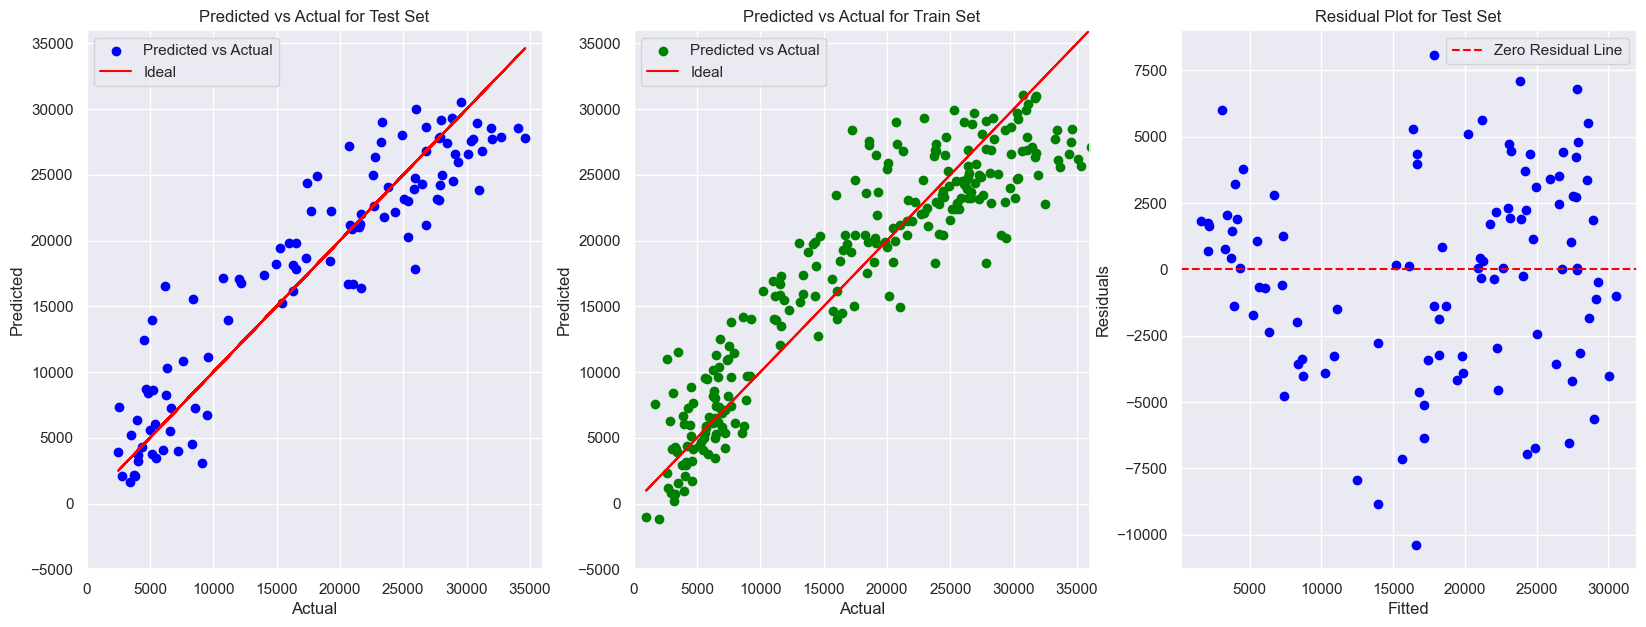

In [21]:
hub_model = HuberRegressor(alpha=1e-3, epsilon=1.35, max_iter=1000) # our best huber model
test_model(hub_model)

Test Accuracy: 83.00%
Train Accuracy: 82.39%
Accuracy Difference: 0.61%
Test Mean Squared Error: 16313198.68
Train Mean Squared Error: 17513785.85
Test Root Mean Squared Error: 4038.96
Alternatively, it's off by an average of 4039 bikes


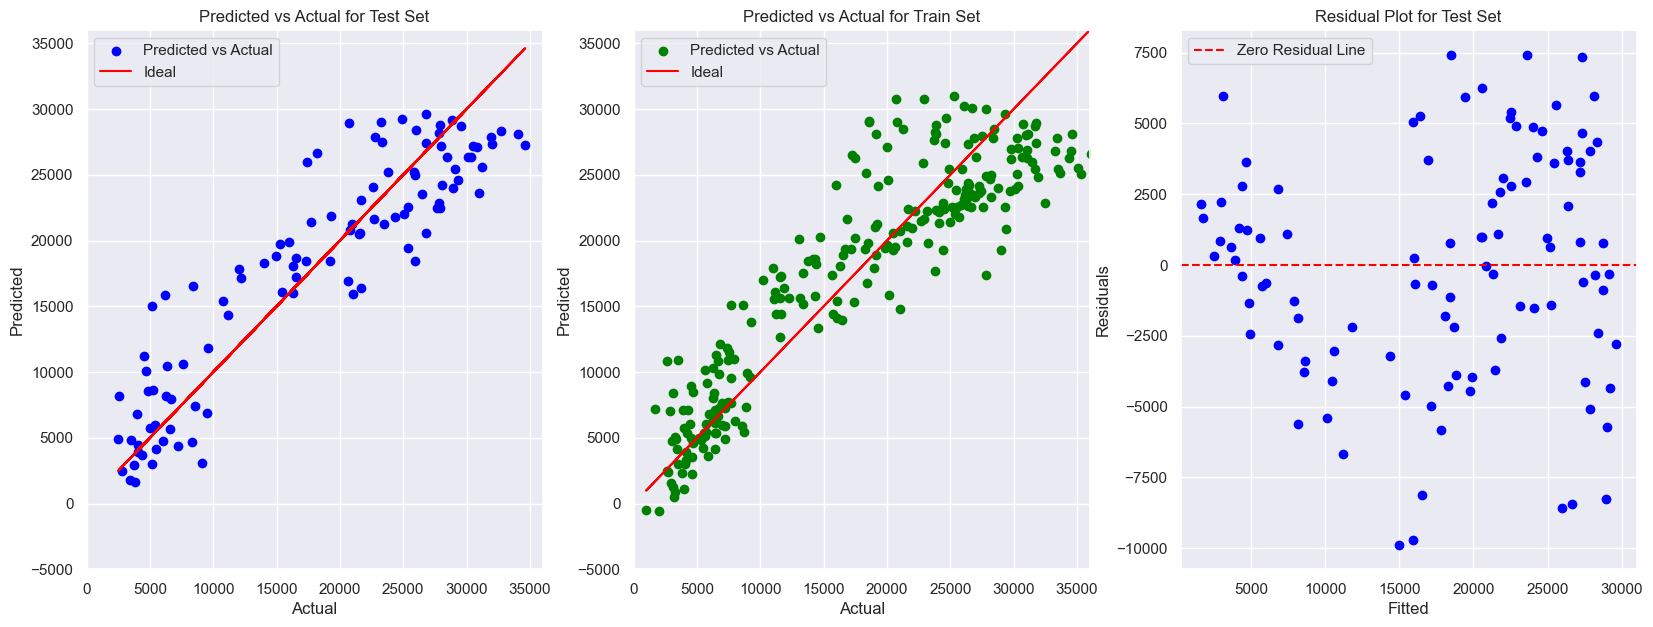

In [13]:
e_model = ElasticNet(alpha=0.1, random_state=1) # our best elastic net model
test_model(e_model)

Test Accuracy: 90.66%
Train Accuracy: 95.29%
Accuracy Difference: -4.63%
Test Mean Squared Error: 8961451.71
Train Mean Squared Error: 4684832.52
Test Root Mean Squared Error: 2993.57
Alternatively, it's off by an average of 2994 bikes


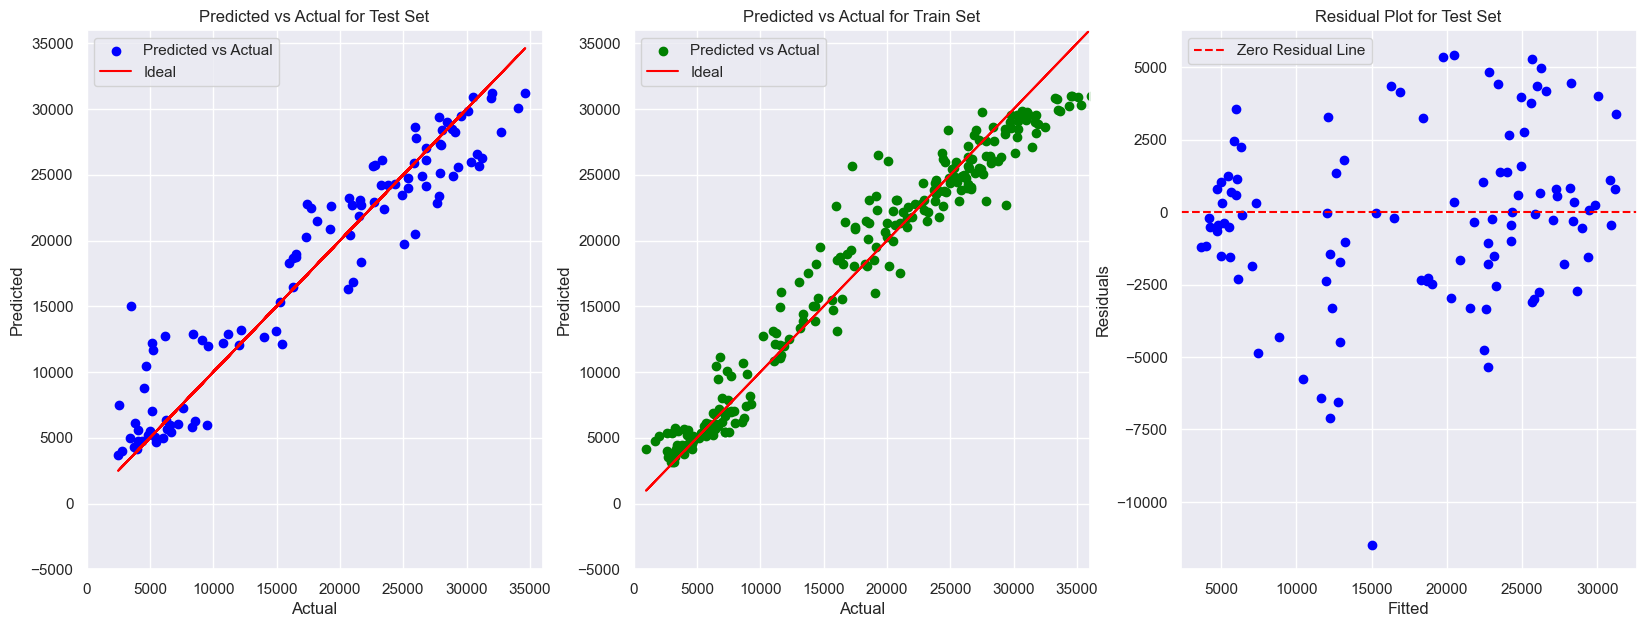

In [14]:
tree_model = ExtraTreesRegressor(max_depth=7,min_samples_leaf=3,min_samples_split=2,n_estimators=363, random_state=1) # our best elastic net model
test_model(tree_model)

# Our Holy Grail

Test Accuracy: 83.06%
Train Accuracy: 82.47%
Accuracy Difference: 0.59%
Test Mean Squared Error: 16261123.54
Train Mean Squared Error: 17436308.71
Test Root Mean Squared Error: 4032.51
Alternatively, it's off by an average of 4033 bikes


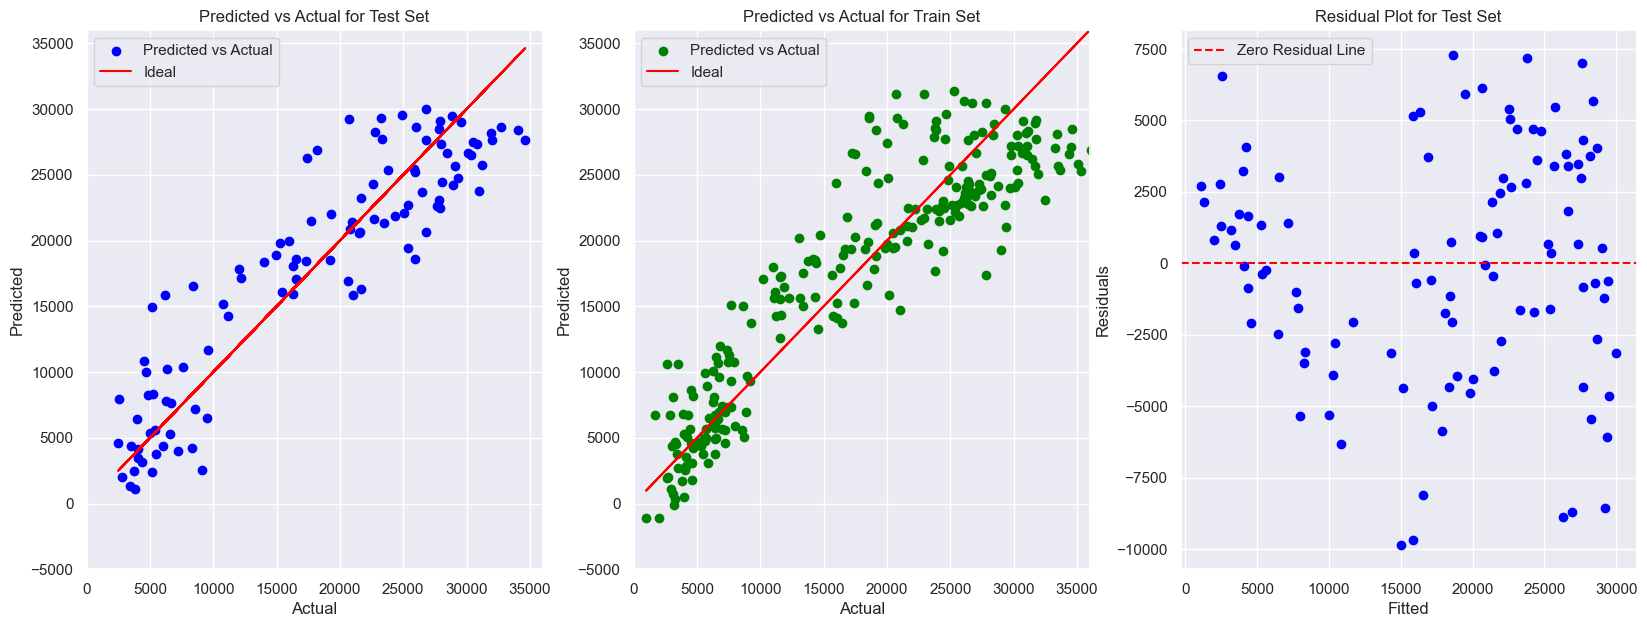

In [15]:
from sklearn.ensemble import StackingRegressor
estimators = [
    ('HuberRegressor', hub_model),
    ('ElasticNet', e_model)
    ]

stack_reg = StackingRegressor(estimators=estimators, cv=cv, n_jobs=-1) # a stacked meta model, still need to find the best combinations through tuning
test_model(stack_reg) # hear me out, i know that rmse looks bad but this is so much better than before so im happy

Stacking it with Ridge seems to work the best so that's our final model

In [19]:
def finalTest(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    final_estimator = model.final_estimator_   
    ridge_intercept = final_estimator.intercept_
    ridge_coefs = final_estimator.coef_
    
    # Simple version of our regression equation
    simple_equation = (f"y = {ridge_intercept:.4f} + {ridge_coefs[0]:.4f} * Huber(x) + {ridge_coefs[1]:.4f} * ElasticNet(x)")
        
    # Get individual model coefs and intercept
    huber_coefs = model.named_estimators_['HuberRegressor'].coef_
    huber_intercept = model.named_estimators_['HuberRegressor'].intercept_
    elastic_coefs = model.named_estimators_['ElasticNet'].coef_
    elastic_intercept = model.named_estimators_['ElasticNet'].intercept_

    # Combined intercept
    total_intercept = ridge_intercept + (ridge_coefs[0] * huber_intercept) + (ridge_coefs[1] * elastic_intercept)

    # Combined coefficients per feature
    combined_weights = []
    for i, feature in enumerate(X.columns):
        combined_weight = (ridge_coefs[0] * huber_coefs[i]) + (ridge_coefs[1] * elastic_coefs[i])
        combined_weights.append((feature, combined_weight))

    # Build the equation string
    final_equation = f"y = {total_intercept:.4f}"
    for feature, weight in combined_weights:
        final_equation += f" + ({weight:.4f} * {feature})"

    # Gathering other metrics
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mse_train = mean_squared_error(y_train, train_pred)
    mse_test = mean_squared_error(y_test, test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    clear_output(True)
    print(f"Regression Equation, in terms of the stacking regressor:\n{simple_equation}")
    print(f"Regression Equation, in terms of the original problem:\n{final_equation}")
    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Test Mean Squared Error: {mse_test:.2f}")
    print(f"Train Mean Squared Error: {mse_train:.2f}")
    print(f"Test Root Mean Squared Error: {rmse_test:.2f}")
    print(f"Train Root Mean Squared Error: {rmse_train:.2f}")

    # Visualizing
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(2, 2, figsize=(20,13))
    ax[0,0].set_title('Predicted vs Actual for Test Set')
    ax[0,0].scatter(y_test, test_pred, color='blue', label='Predicted vs Actual')
    ax[0,0].plot(y_test, y_test, color='red', label='Ideal')
    ax[0,0].legend()
    ax[0,0].set_xlim(0, 36000)
    ax[0,0].set_ylim(-5000, 36000)
    ax[0,0].set_xlabel('Actual')
    ax[0,0].set_ylabel('Predicted')

    ax[0,1].set_title('Predicted vs Actual for Train Set')
    ax[0,1].scatter(y_train, train_pred, color='green', label='Predicted vs Actual')
    ax[0,1].plot(y_train, y_train, color='red', label='Ideal')
    ax[0,1].legend()
    ax[0,1].set_xlim(0, 36000)
    ax[0,1].set_ylim(-5000, 36000)
    ax[0,1].set_xlabel('Actual')
    ax[0,1].set_ylabel('Predicted')

    test_residuals = y_test.reshape(-1,1) - test_pred.reshape(-1,1)
    ax[1,0].set_title('Residual Plot for Test Set')
    ax[1,0].scatter(test_pred, test_residuals, color='blue')
    ax[1,0].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[1,0].legend()
    ax[1,0].set_xlim(-5000, 35000)
    ax[1,0].set_ylim(-14000, 13000)
    ax[1,0].set_xlabel("Fitted")
    ax[1,0].set_ylabel("Residuals")

    train_residuals = y_train.reshape(-1,1) - train_pred.reshape(-1,1)
    ax[1,1].set_title('Residual Plot for Train Set')
    ax[1,1].scatter(train_pred, train_residuals, color='green')
    ax[1,1].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[1,1].legend()
    ax[1,1].set_xlim(-5000, 35000)
    ax[1,1].set_ylim(-14000, 13000)
    ax[1,1].set_xlabel("Fitted")
    ax[1,1].set_ylabel("Residuals")
    
    plt.show()

Regression Equation, in terms of the stacking regressor:
y = -59.8381 + 1.3588 * Huber(x) + -0.3538 * ElasticNet(x)
Regression Equation, in terms of the original problem:
y = 21442.5055 + (6096.0886 * Temperature(C)) + (403.3250 * Humidity(%)) + (-530.4617 * Wind speed (m/s)) + (609.6913 * Visibility (10m)) + (2656.5225 * Solar Radiation (MJ/m2)) + (-79.1618 * Precipitation (cm)) + (2226.4483 * Rainfall(mm)) + (-3302.0868 * Snowfall (cm)) + (-7290.8431 * Spring) + (8716.0167 * Summer) + (-7031.5891 * Winter) + (294.6582 * Spring_Temp) + (-560.1276 * Summer_Temp) + (-278.8207 * Winter_Temp)
Test Accuracy: 85.25%
Train Accuracy: 85.46%
Accuracy Difference: -0.22%
Test Mean Squared Error: 14160869.86
Train Mean Squared Error: 14458515.98
Test Root Mean Squared Error: 3763.09
Train Root Mean Squared Error: 3802.44


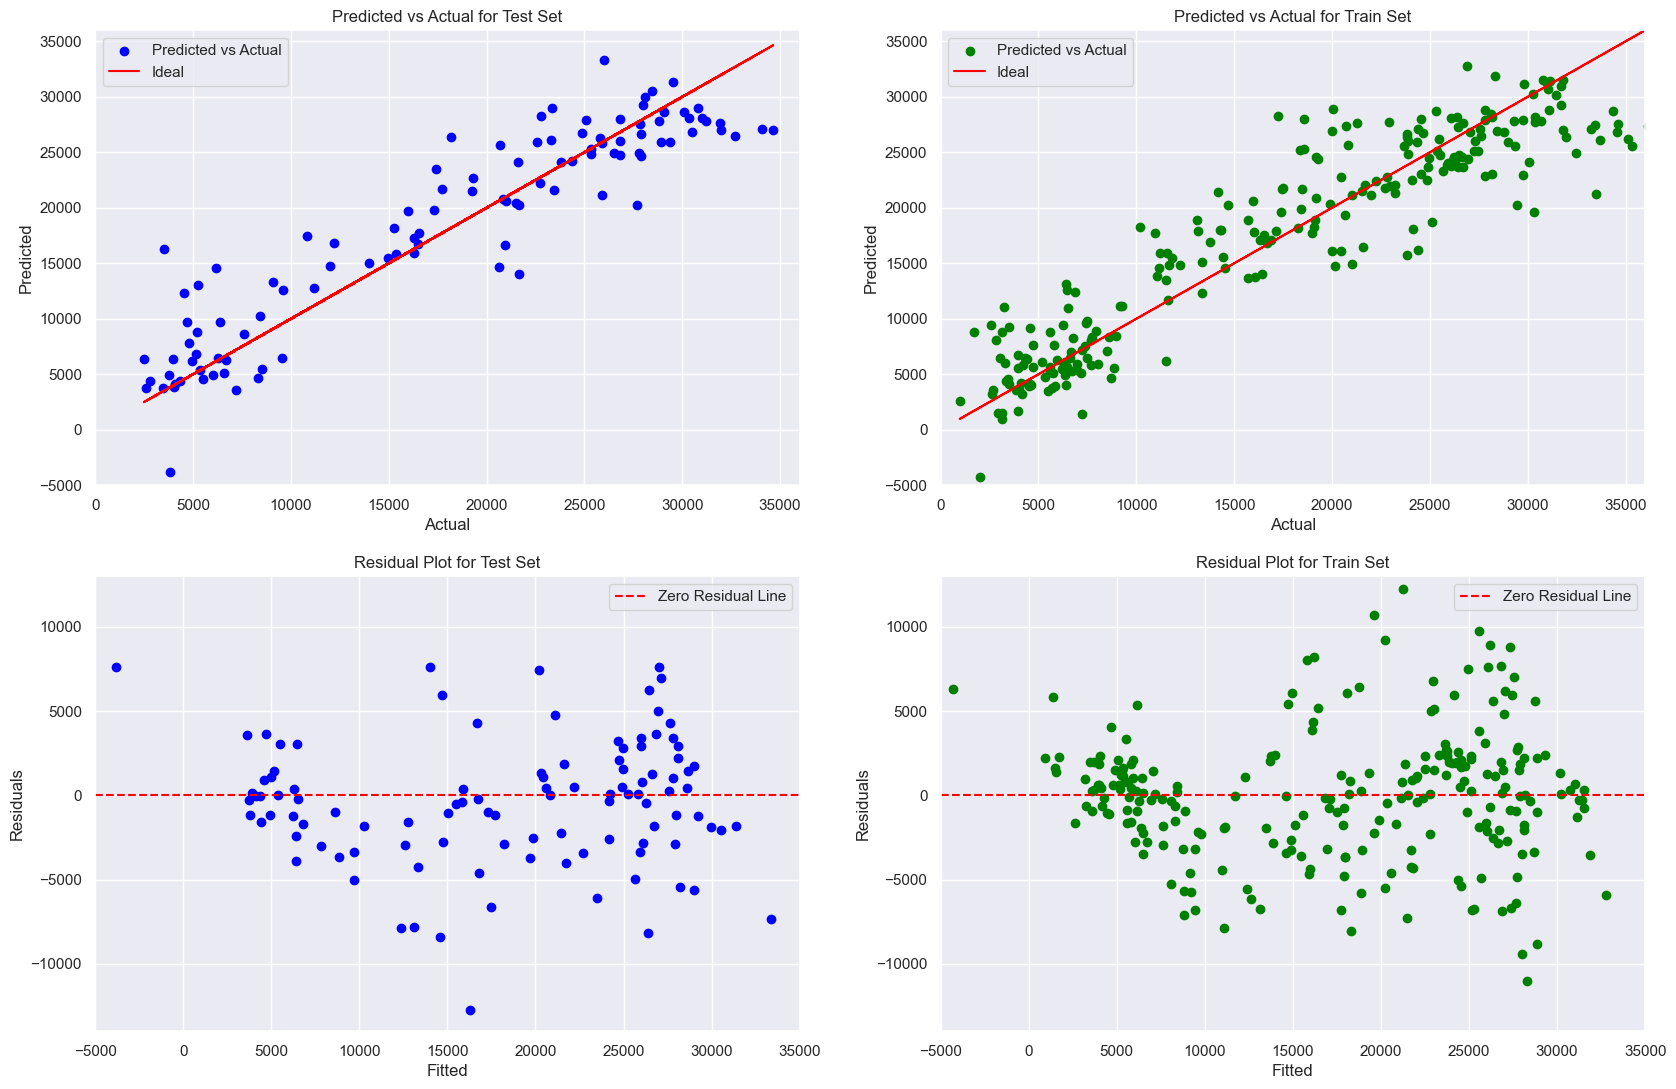

In [20]:
finalTest(stack_reg)